# Updated pre-transformation for sea ice concentration dataset G02202 v5 

2025-09-15

In [375]:
import xarray as xr
import numpy as np
from pprint import pprint

In [368]:
def ice_or_not_mask(x_da):
    cdr_seaice_presence = x_da.copy(deep=True)
    cdr_seaice_presence.values[:] = 0.0
    cdr_seaice_presence.values[x_da > 0] = 1
    return cdr_seaice_presence

## The routine that does the masking

In [369]:
def G02202v5_mask_flagged_conc(ds: xr.Dataset, debug_plotting=False) -> xr.Dataset:
        """
        2025-09-15 rewrite based on v5 version of G02202
        https://nsidc.org/data/g02202/versions/5

        This subroutine masks out some sea ice concentration values from the 
        'cdr_seaice_conc' field in G02202 v5 datasets, based on
        their quality assurance (QA) flags in the 'cdr_seaice_conc_qa_flag' field.

        Specifically, we set sea ice concentration values to NaN where any of the following are true:
        spatial interpolation, temporal interpolation, no observations
        
        where there are no obs, the data producers sometimes fill the gaps
        via interpolation. we're not going to use their interpolated values
        where there are no obs or interpolation, we mask to nan.

        For detailed description of QA flags see 
        https://nsidc.org/sites/default/files/documents/user-guide/g02202-v005-userguide.pdf

        QA Flag Meanings

        flag_meanings = [
            "BT_weather_filter_applied",        # 2**0 = 1
            "NT_weather_filter_applied",        # 2**1 = 2
            "land_spillover_applied",           # 2**2 = 4
            "no_input_data",                    # 2**3 = 8     
            "invalid_ice_mask_applied",         # 2**4 = 16
            "spatial_interpolation_applied",    # 2**5 = 32
            "temporal_interpolation_applied",   # 2**6 = 64
            "melt_start_detected"               # 2**7 = 128
        ] 

        The BT and NT weather filters and land spillover filters set the sea ice concentration to zero (open ocean)
        so we do not mask out those values
        The invalid ice mask is where ice is never present, so we do not mask those values (they are already zero)
        The melt start detected flag indicates melting ice, which is not a dealbreaker for us
        but we could have a higher uncertainty there.   

        Parameters
        ----------
        ds : xr.Dataset
            Input dataset containing 'cdr_seaice_conc' and 'cdr_seaice_conc_qa_flag' variables.
        debug_plotting : bool, optional
            If True, generates debug plots before and after QA flag application, by default False.      
        Returns
        -------
        xr.Dataset
            Dataset with 'cdr_seaice_conc' values masked to NaN based on QA flags.
        """

        # the NASA cdr sea ice concentration data array
        cdr_seaice_conc = ds["cdr_seaice_conc"]
        
        # log the sum of all conc values > 1 before any masking      
        logger.debug(
            f'G2202 masking flagged CDR pre : {np.sum(cdr_seaice_conc.values.ravel() > 1)}'
        )
        
        # Create a QA Flag DataArray
        # ---------------------------------
        # make a new data array object of dimension [n_flags, y, x]
        # where n_flags = 8, the number of different qa flags 

        # the cdf qa flags
        qa_flags = ds['cdr_seaice_conc_qa_flag']
        
        # first find the bit values
        # 8 flags, 2^0, 2^1, ..., 2^7
        n = 8
        field = qa_flags.values.astype(np.uint64)     # ensure integer dtype
        bits  = (1 << np.arange(n, dtype=np.uint64))  # [1,2,4,...,2**(n-1)]

        # flags has shape (n, *field.shape); flags[k] is 1 where bit 2**k is set
        # .. thank you chatgpt, I don't know how this works

        flags = ((field[None, ...] & bits[:, None, *([None]*qa_flags.ndim)]) != 0).astype(np.uint8)

        # then make a list of data array objects, one for each flag of dimension [y,x]
        flag_das = []
        for n in range(8):
            print(f'flag key is 2^{n} = {2**n}')
            flag_da_tmp = xr.DataArray(flags[n,0,0], dims=['y','x'], coords={'flag':2**n})
            flag_da_tmp.name=f'qa_flag{n}'
            flag_das.append(flag_da_tmp)

        # then concat the qa flag arrays along the 'flag' dimension
        flag_das = xr.concat(flag_das,dim='flag')
        flag_das.attrs['flag_meanings'] = flag_meanings

        # finally, set to NaN any qa flag values > 0 (indicating the qa flag is set)
        flag_das.values = np.where(flag_das.values > 0, np.nan, 1)

        # Apply QA flags
        # -------------------------      
        # apply some QA flags, specifically 
        flags_to_nan = [3, 5, 6] # 2^3=8, 2^5=32, 2^6=64
        
        # flag 2^3 = 8  : No input data
        # flag 2^5 = 32 : spatial interpolation applied
        # flag 2^6 = 64 : temporal interpolation applied

        # do not nan out flags 2^0, 2^1, 2^2 : BT and NT weather filter applied
        #    and land spillover applied.  these indicate that the sea ice conc was
        #    set to zero (open ocean). without these filters, spurious nonzero sea ice 
        #    concentrations could be present due to weather effects or land spillover
        # 
        # do not nan out flag 16 (2**4) "invalid ice mask" (ice is never present there)
        # 
        # do not nan out flag 128 (2**7) "melt start detected" (ice is melting)
        #                                 melting ice doesn't mean bad data not a dealbreaker
        #                                 although we could have a higher uncertainty

        # make a copy of the original conc field to apply the QA flags to
        cdr_seaice_conc_post_qa = cdr_seaice_conc.copy(deep=True)

        # loop through the flags_to_nan, and multiply the conc field with the 
        # corresponding 'flag_das' field, which is labelled on the 'flag' dimension 
        # as 2**n 
        for n in flags_to_nan:
            print(f'nanning out flag={2**n}  {flag_das.attrs["flag_meanings"][n]}')
            cdr_seaice_conc_post_qa = cdr_seaice_conc_post_qa * flag_das.sel(flag=2**n)
    
        if debug_plotting:
            f,axs = plt.subplots(1,2, figsize=[10,5]);
            axs=axs.ravel()
            cdr_seaice_conc.plot(ax=axs[0])
            cdr_seaice_conc_post_qa.plot(ax=axs[1])
        
        # replace the original conc field with the post-QA field
        ds['cdr_seaice_conc'].values[:] = cdr_seaice_conc_post_qa.values[:]

        logger.debug(
            f"G2202 masking flagged CDR post: {np.sum(ds['cdr_seaice_conc'].values.ravel())}"
        )
        # finally, drop the qa flag fields and other unneeded fields
        ds = ds.drop_vars(['cdr_seaice_conc_interp_spatial_flag',
                           'cdr_seaice_conc_qa_flag',
                           'cdr_seaice_conc_interp_temporal_flag',
                           'cdr_seaice_conc_stdev'])
        return ds

## Load a test dataset and run it through the masking subroutine

In [376]:
test_nc = xr.open_dataset('/Users/ifenty/Downloads/sic_psn25_19800101_n07_v05r00.nc')

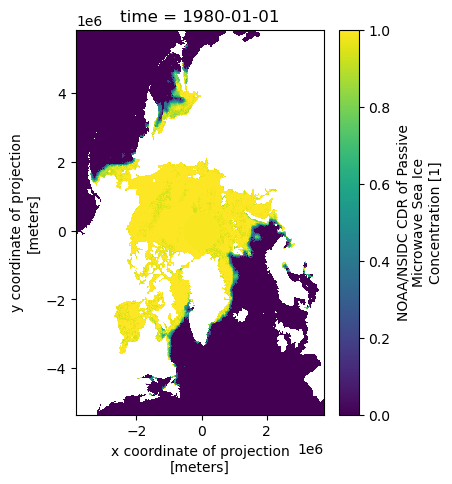

In [377]:
test_nc['cdr_seaice_conc'].plot(figsize=[4,5])

In [378]:
import logging

# Configure basic logging to the console (default level is WARNING)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Get a logger instance
logger = logging.getLogger(__name__)

In [379]:
test_nc.data_vars

Data variables:
    crs                                   int32 4B ...
    cdr_seaice_conc_interp_spatial_flag   (time, y, x) uint8 136kB ...
    cdr_seaice_conc_qa_flag               (time, y, x) uint8 136kB ...
    cdr_seaice_conc_interp_temporal_flag  (time, y, x) uint8 136kB ...
    cdr_seaice_conc                       (time, y, x) float64 1MB ...
    cdr_seaice_conc_stdev                 (time, y, x) float32 545kB ...

flag key is 2^0 = 1
flag key is 2^1 = 2
flag key is 2^2 = 4
flag key is 2^3 = 8
flag key is 2^4 = 16
flag key is 2^5 = 32
flag key is 2^6 = 64
flag key is 2^7 = 128
nanning out flag=8  No_input_data
nanning out flag=32  spatial_interpolation_applied
nanning out flag=64  temporal_interpolation_applied


<xarray.Dataset> Size: 1MB
Dimensions:          (time: 1, y: 448, x: 304)
Coordinates:
  * x                (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time             (time) datetime64[ns] 8B 1980-01-01
Data variables:
    crs              int32 4B ...
    cdr_seaice_conc  (time, y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-11T23:59:35Z
    time_coverage_start:       1980-01-01T00:00:00Z
    time_coverage_end:         1980-01-01T23:59:59Z
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    ...                        ...
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

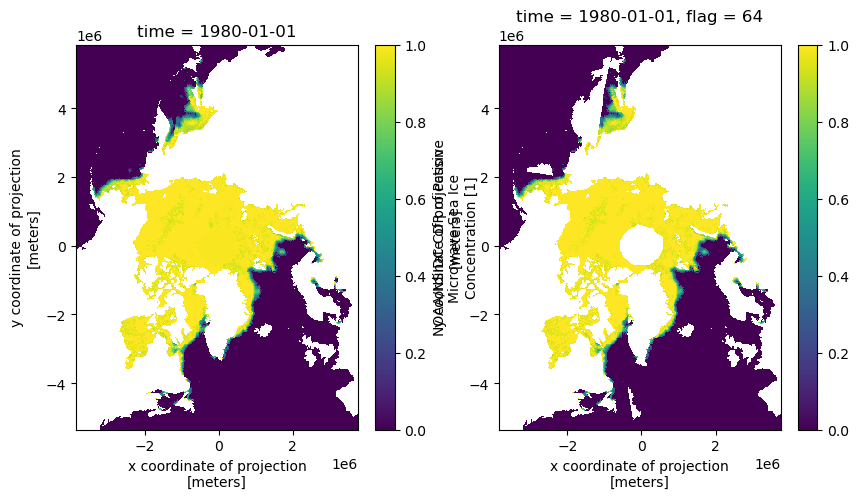

In [380]:
ds_new = G02202v5_mask_flagged_conc(ds=test_nc, debug_plotting=True)
ds_new

In [381]:
ds_new

<xarray.Dataset> Size: 1MB
Dimensions:          (time: 1, y: 448, x: 304)
Coordinates:
  * x                (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time             (time) datetime64[ns] 8B 1980-01-01
Data variables:
    crs              int32 4B ...
    cdr_seaice_conc  (time, y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-11T23:59:35Z
    time_coverage_start:       1980-01-01T00:00:00Z
    time_coverage_end:         1980-01-01T23:59:59Z
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    ...                        ...
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

# Development area

In [228]:
cdr_seaice_conc = test_nc['cdr_seaice_conc'].copy(deep=True)

In [313]:
qa_flags = test_nc['cdr_seaice_conc_qa_flag']

In [358]:
# make a new data array object of dimension [n_flags, y, x]
# where n_flags = 8, the number of different qa flags 

# first find the bit values
# 8 flags, 2^1, 2^2, ,  2^8
n = 8
field = qa_flags.values.astype(np.uint64)           # ensure integer dtype
bits  = (1 << np.arange(n, dtype=np.uint64))  # [1,2,4,...,2**(n-1)]

# flags has shape (n, *field.shape); flags[k] is 1 where bit 2**k is set
flags = ((field[None, ...] & bits[:, None, *([None]*qa_flags.ndim)]) != 0).astype(np.uint8)

# then make a data array object, one for each flag
flag_das = []
for n in range(8):
    print(f'flag key is 2^{n} = {2**n}')
    flag_da_tmp = xr.DataArray(flags[n,0,0], dims=['y','x'], coords={'flag':2**n})
    flag_da_tmp.name=f'qa_flag{n}'
    flag_das.append(flag_da_tmp)

# then concat the qa flag arrays along the 'flag' dimension
flag_das = xr.concat(flag_das,dim='flag')
flag_das.attrs['flag_meanings'] = flag_meanings

# finally, set to nan any qa flag values with a 1 (indicating the qa flag is set)
flag_das.values = np.where(flag_das.values > 0, np.nan, 1)

flag_das.attrs['flag_meanings'] = flag_meanings
pprint(flag_meanings)

flag key is 2^0 = 1
flag key is 2^1 = 2
flag key is 2^2 = 4
flag key is 2^3 = 8
flag key is 2^4 = 16
flag key is 2^5 = 32
flag key is 2^6 = 64
flag key is 2^7 = 128
['BT_weather_filter_applied',
 'NT_weather_filter_applied',
 'Land_spillover_filter_applied',
 'No_input_data',
 'invalid_ice_mask_applied',
 'spatial_interpolation_applied',
 'temporal_interpolation_applied',
 'melt_start_detected']


# examine the flags

## QA flag

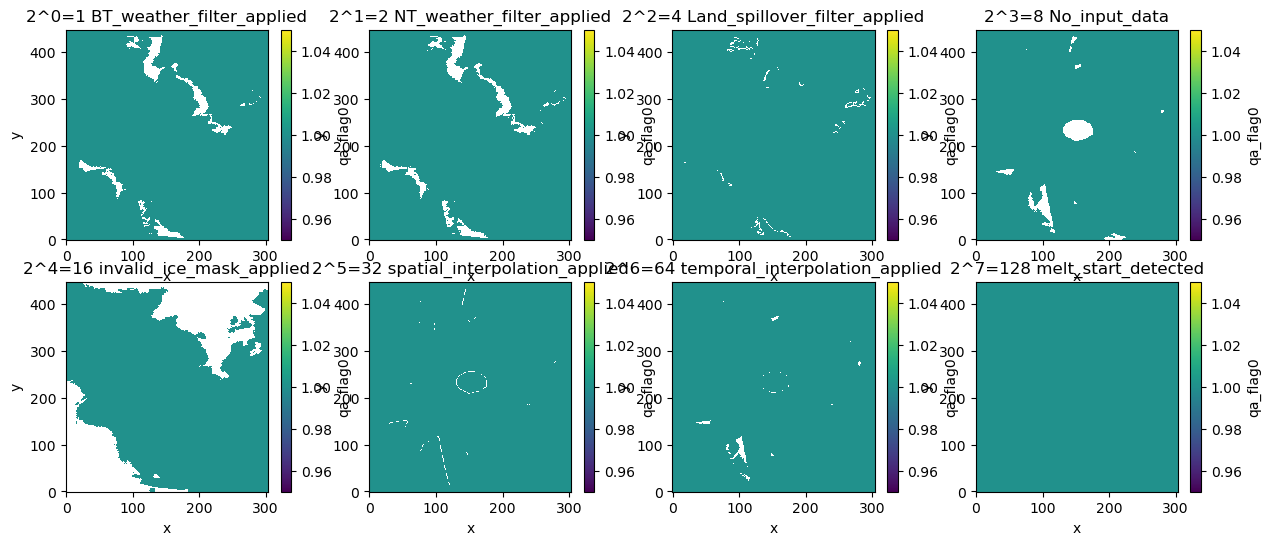

In [262]:
f,axs = plt.subplots(2,4, figsize=[15,6]);
axs=axs.ravel()
for n in range(8):
    flag_das.isel(flag=n).plot(ax=axs[n])
    axs[n].set_title(f'2^{n}={2**n} {flag_das.flag_meanings[n]}')

## Temporal Interpolation Flag

{'comment': 'Value of 0 indicates no temporal interpolation occurred.  Values '
            "greater than 0 and less than or equal to 55 are of the form 'AB' "
            "where 'A' indicates the number of days prior to the current day "
            "and 'B' indicates the number of days after the current day used "
            'to linearly interpolate the data.  If either A or B are zero, the '
            'value was extrapolated from that date rather than interpolated.  '
            'A value of 255 indicates that temporal interpolation could not be '
            'accomplished.',
 'flag_meanings': 'no_temporal_interp 1_day_after 2_days_after 3_days_after '
                  '1_day_prior 1_day_prior_and_1_day_after '
                  '1_day_prior_and_2_days_after 1_day_prior_and_3_days_after '
                  '1_day_prior_and_4_days_after 1_day_prior_and_5_days_after '
                  '2_days_prior 2_days_prior_and_1_day_after '
                  '2_days_prior_and_2_days_after 2_

Text(0.5, 1.0, 'temporal interpolation flag')

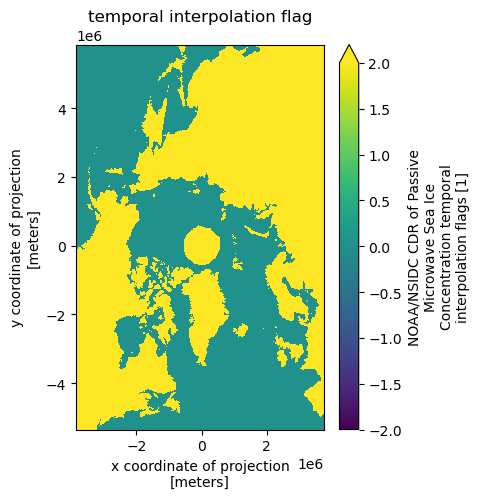

In [305]:
temporal_interp_flags = test_nc['cdr_seaice_conc_interp_temporal_flag']
pprint(temporal_interp_flags.attrs)
print('\n flag meanings')
pprint(temporal_interp_flags.attrs['flag_meanings'].split(' '))

#plt.figure(
temporal_interp_flags.plot(figsize=(4,5), vmin=-2,vmax=2)
plt.title('temporal interpolation flag')

## Spatial interpolation flag

{'flag_masks': array([ 1,  2,  4,  8, 16, 32], dtype=uint8),
 'flag_meanings': '19v_tb_value_interpolated 19h_tb_value_interpolated '
                  '22v_tb_value_interpolated 37v_tb_value_interpolated '
                  '37h_tb_value_interpolated '
                  'pole_hole_spatially_interpolated_(Arctic_only)',
 'grid_mapping': 'crs',
 'long_name': 'NOAA/NSIDC CDR of Passive Microwave Sea Ice Concentration '
              'spatial interpolation flags',
 'standard_name': 'status_flag',
 'units': '1',
 'valid_range': array([ 0, 63], dtype=uint8)}

 flag meanings
['19v_tb_value_interpolated',
 '19h_tb_value_interpolated',
 '22v_tb_value_interpolated',
 '37v_tb_value_interpolated',
 '37h_tb_value_interpolated',
 'pole_hole_spatially_interpolated_(Arctic_only)']


Text(0.5, 1.0, 'spatial interpolation flag')

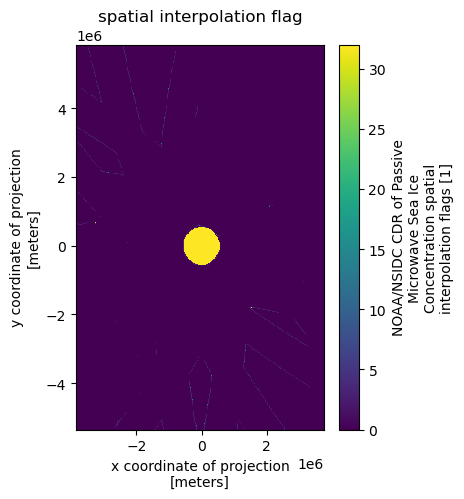

In [249]:
spatial_interp_flags = test_nc['cdr_seaice_conc_interp_spatial_flag']
pprint(spatial_interp_flags.attrs)
print('\n flag meanings')
pprint(spatial_interp_flags.attrs['flag_meanings'].split(' '))

#plt.figure(
spatial_interp_flags.plot(figsize=(4,5))
plt.title('spatial interpolation flag')

# Apply flags to data

## QA flags

[3, 5, 6]
nanning out flag=8  No_input_data
nanning out flag=32  spatial_interpolation_applied
nanning out flag=64  temporal_interpolation_applied


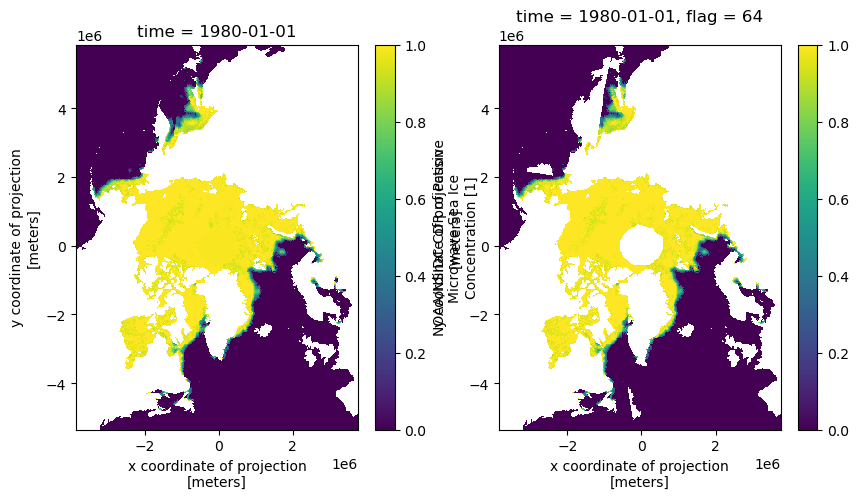

In [306]:
# apply the QA flags, except flag 2^7, the melt start detected.
# melt start detected should lower the uncertainty
# but it isn't extreme enough for us to remove the data altogether

# only nan out 2^0 = 1, 2^1=2, ... 2^6 = 64
flags_to_nan = [3, 5, 6] # 2^3=8, 2^5=32, 2^6=64
# flag 8 : No input data
# flag 32 : spatial interpolation applied
# flag 64 : temporal interpolation applied

# do not nan out flags 2^0, 2^1, 2^2 : BT and NT weather filter applied
# and land spillover applied.  these indicate that the sea ice conc was
# set to zero (open ocean). without these filters, spurious nonzero sea ice 
# concentrations could be present due to weather effects or land spillover
# 
# also do not nan out flag 16 (2**4) "invalid ice mask" (ice is never present there)
# do not nan out flag 128 (2**7) "melt start detected" (ice is melting)
# ice is melting is not a dealbreaker

pprint(flags_to_nan)

cdr_seaice_conc_post_qa = cdr_seaice_conc.copy(deep=True)
for n in flags_to_nan:
    print(f'nanning out flag={2**n}  {flag_das.attrs["flag_meanings"][n]}')
    cdr_seaice_conc_post_qa = cdr_seaice_conc_post_qa * flag_das.sel(flag=2**n)
    
#cdr_seaice_conc_post_qa.values[flag_das[4].plot()]
f,axs = plt.subplots(1,2, figsize=[10,5]);
axs=axs.ravel()
cdr_seaice_conc.plot(ax=axs[0])
cdr_seaice_conc_post_qa.plot(ax=axs[1])

In [307]:
# cdr_seaice_conc_post_qa  is what needs to be saved

In [308]:
ice_or_not_post_qa = ice_or_not_mask(cdr_seaice_conc_post_qa)
ice_or_not_pre_qa = ice_or_not_mask(cdr_seaice_conc)

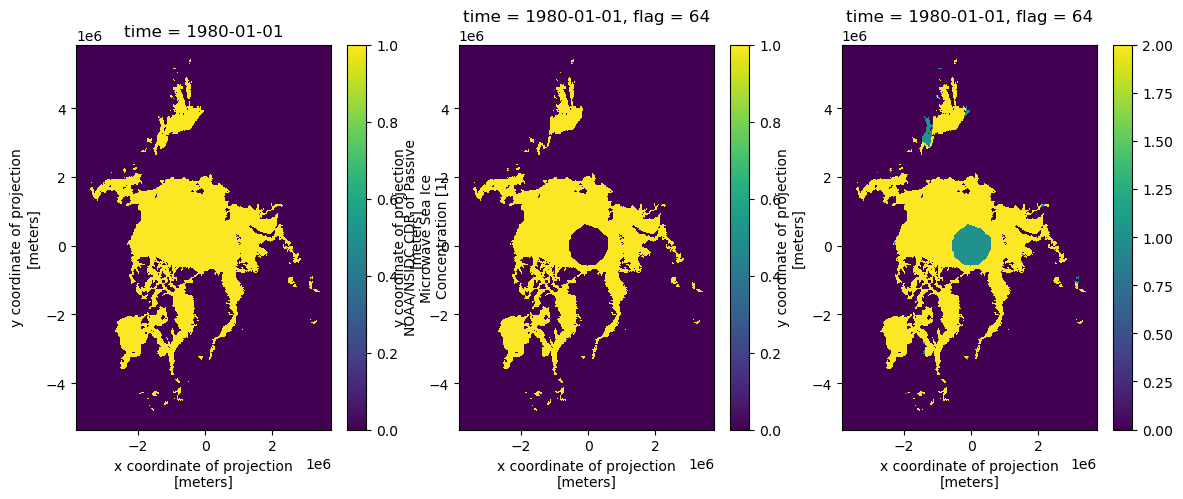

In [310]:
#cdr_seaice_conc_post_qa.values[flag_das[4].plot()]
f,axs = plt.subplots(1,3, figsize=[14,5]);
axs=axs.ravel()
ice_or_not_pre_qa.plot(ax=axs[0])
ice_or_not_post_qa.plot(ax=axs[1])
(ice_or_not_pre_qa+ice_or_not_post_qa).plot(ax=axs[2])

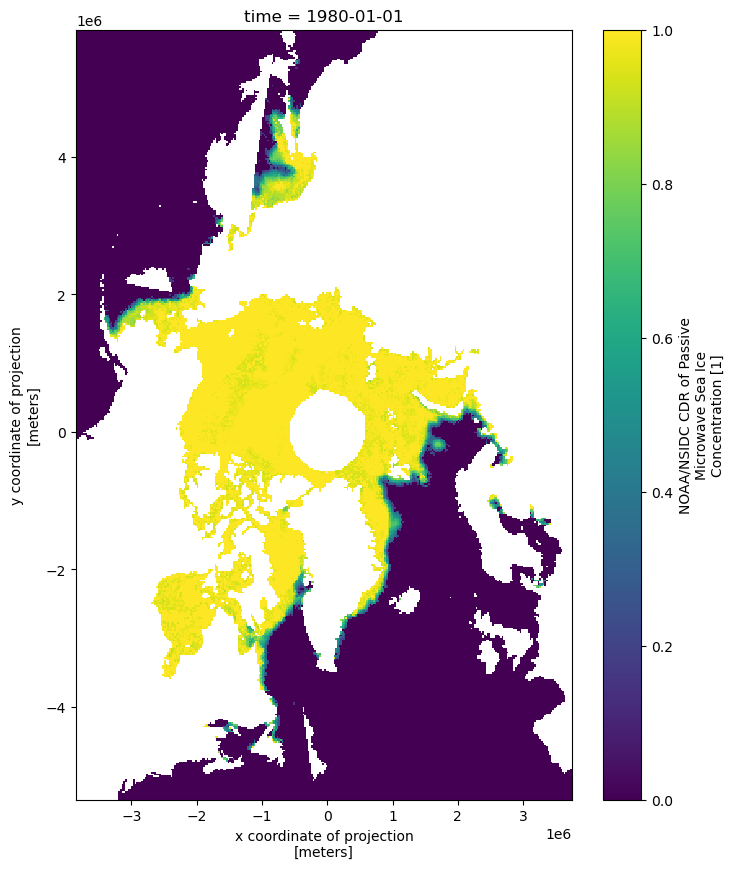

In [365]:
ds_new['cdr_seaice_conc'].plot(figsize=[8,10])

In [366]:
ds_new

<xarray.Dataset> Size: 1MB
Dimensions:          (time: 1, y: 448, x: 304)
Coordinates:
  * x                (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time             (time) datetime64[ns] 8B 1980-01-01
Data variables:
    crs              int32 4B ...
    cdr_seaice_conc  (time, y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-11T23:59:35Z
    time_coverage_start:       1980-01-01T00:00:00Z
    time_coverage_end:         1980-01-01T23:59:59Z
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    ...                        ...
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east